In [1]:
%load_ext autoreload

In [2]:
%autoreload 2 
import sys, os, glob
import numpy as np, pandas as pd, matplotlib.pyplot as plt, datetime as dt

sys.path.append("../src/")
from caliop import *
from collocation import *

/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/vmeijer/.local/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Show cloud filtered CALIOP L1 backscatter

In [3]:
caliop_l1_path = "/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L1/" \
                   + "CAL_LID_L1-Standard-V4-10.2018-01-01T20-44-02ZD_Subset.hdf"

In [4]:
ca = CALIOP(caliop_l1_path)

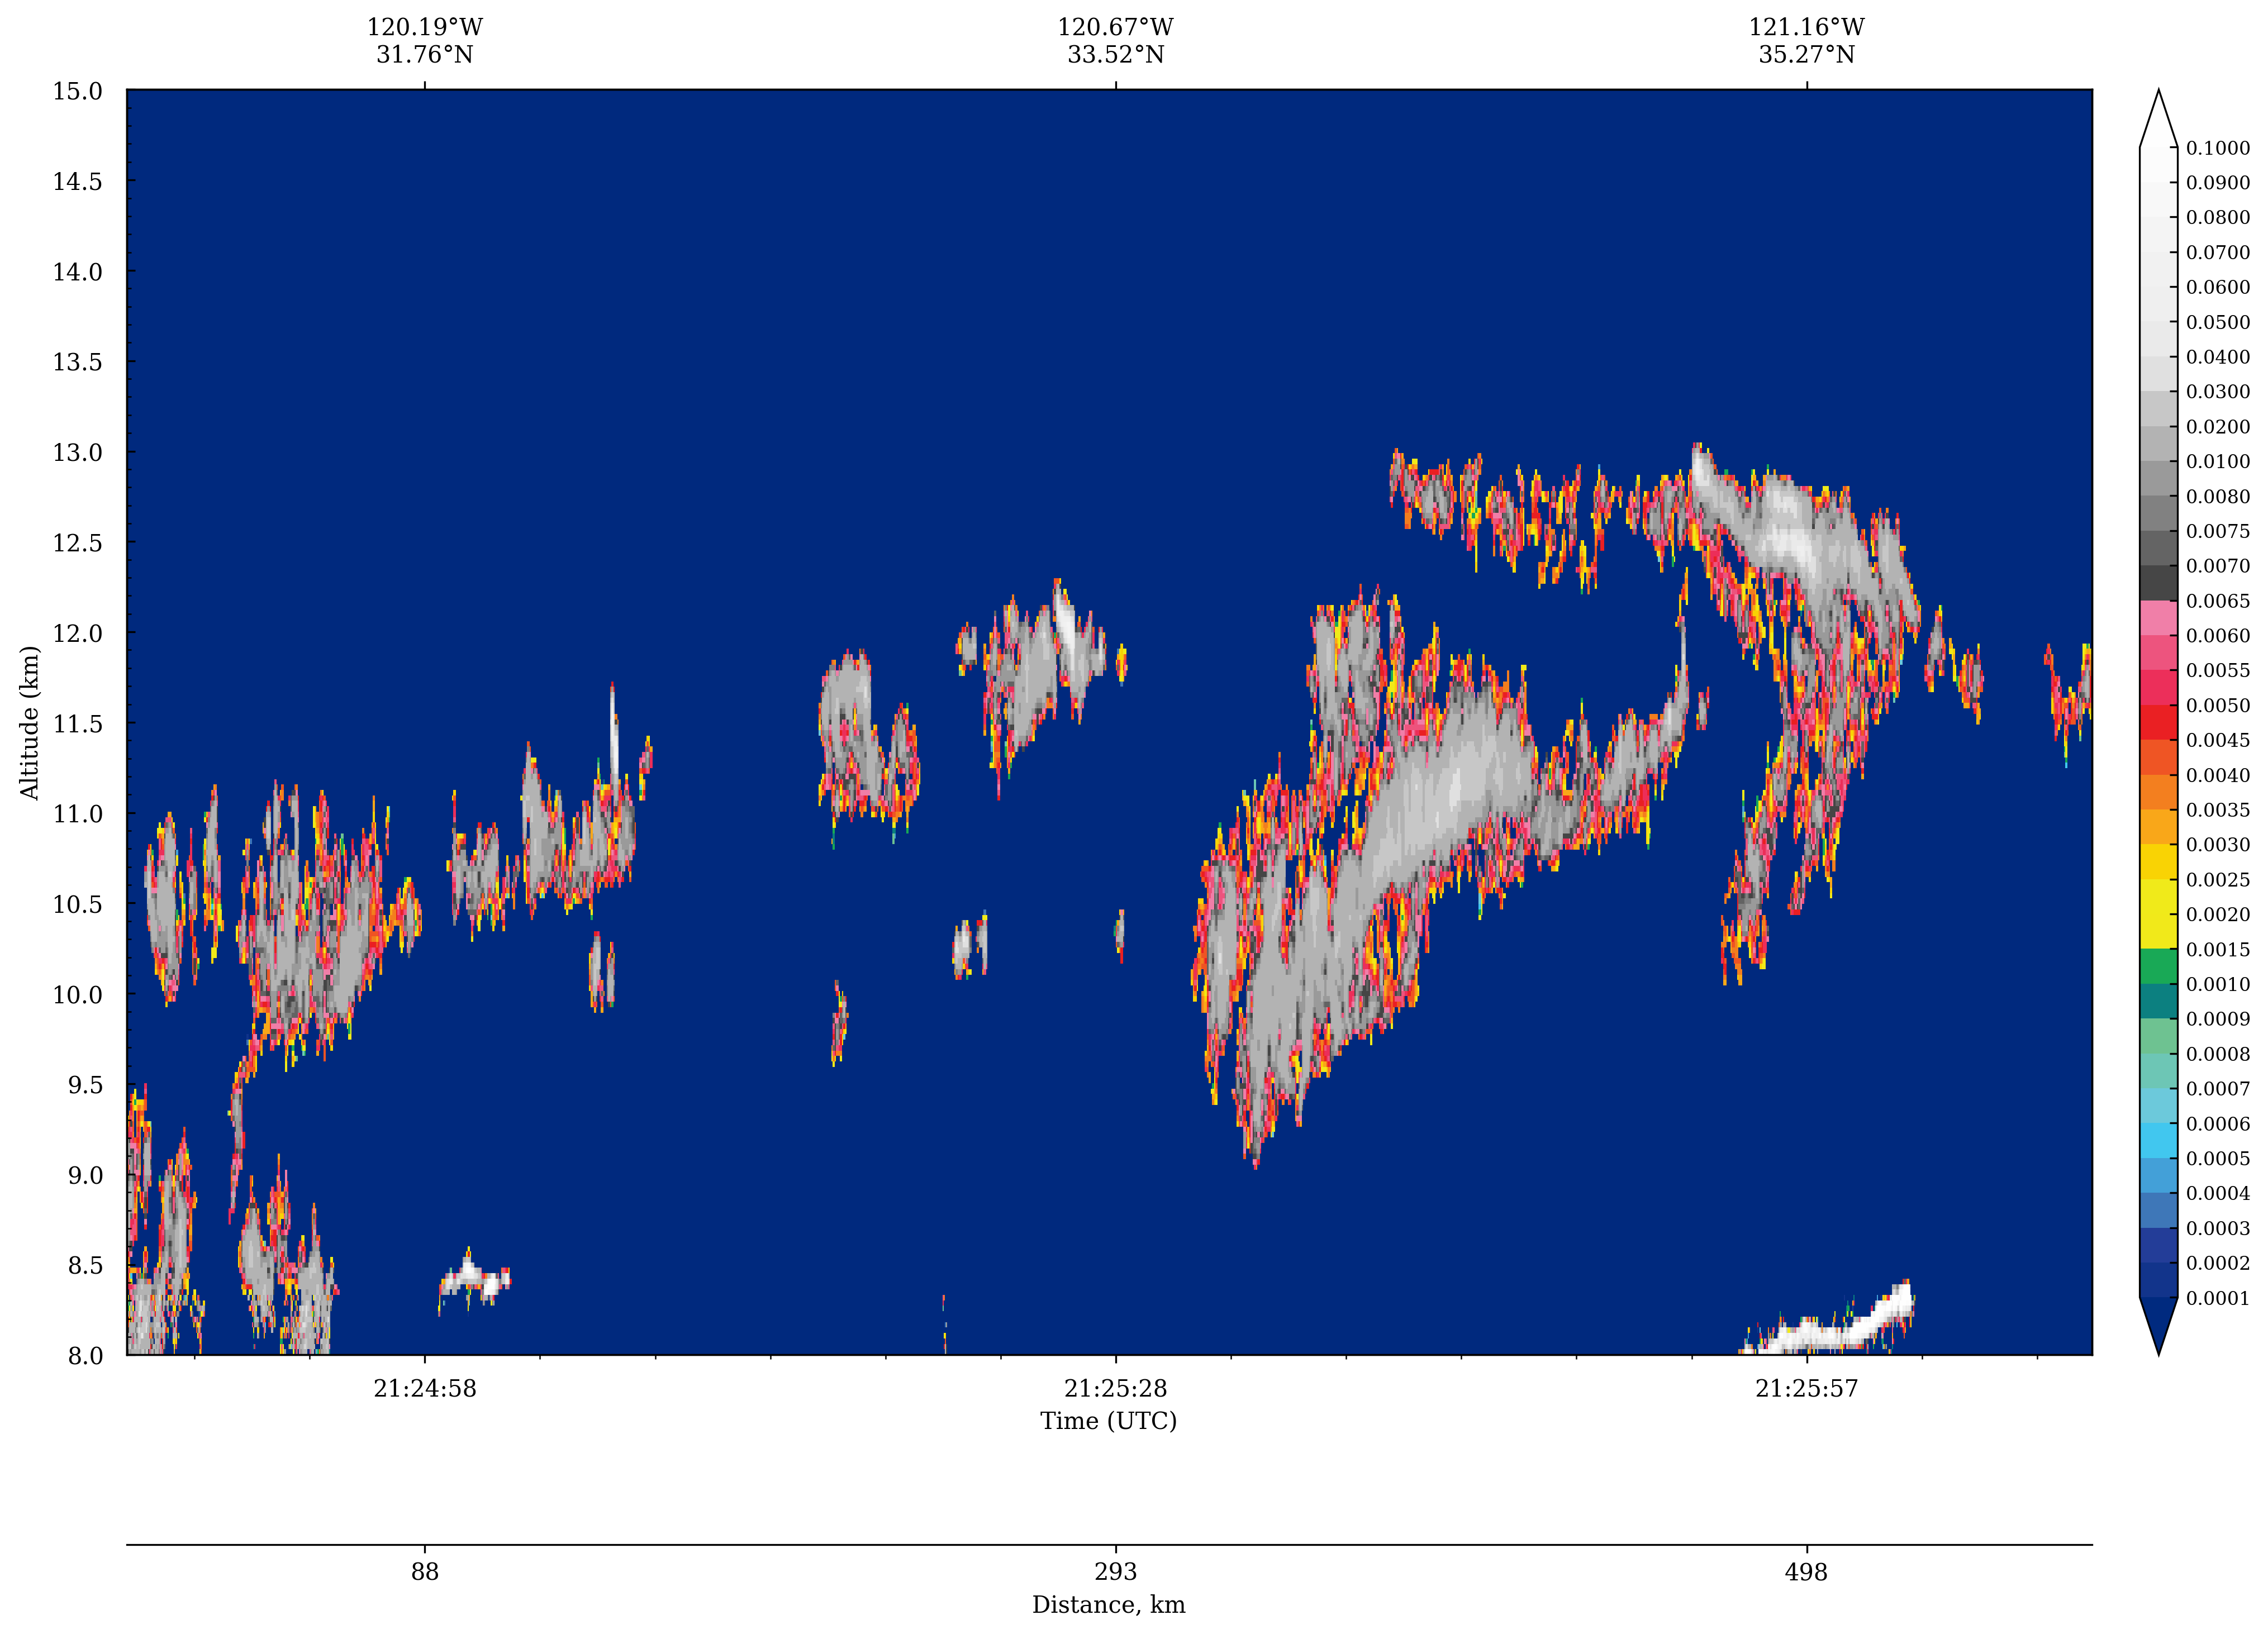

In [5]:
fig, ax = plt.subplots(dpi=300, figsize=(15, 10))
ca.plot_backscatter(colorbar=True, cloud_filter=True, fig=fig, ax=ax, min_alt=8,
       max_alt=15.0, dist_axis=True, extent=[-135, -65, 31, 36])

# Perform coarse collocation

In [6]:
!ls /net/d13/data/vmeijer/data/orthographic_detections_goes16/ABI-L2-MCMIPC/2018/001/21

20180101_21_25.csv


In [7]:
def get_mask(time, conus=False):

    if conus:
        path = "/net/d13/data/vmeijer/data/orthographic_detections_goes16/" \
                + "ABI-L2-MCMIPC" + time.strftime("/%Y/%j/%H/%Y%m%d_%H_%M.csv")
        try:
            df = pd.read_csv(path) 
        except FileNotFoundError as e:
            raise FileNotFoundError(f"No detection found at {path}")
            
        mask = np.zeros((2000, 3000))
        mask[df.row.values, df.col.values] = 1
        return mask
    else:
        df = pd.read_csv("/home/vmeijer/covid19/data/predictions_wo_sf/" + time.strftime('%Y%m%d.csv'))
        df.datetime = pd.to_datetime(df.datetime)
        df = df[df.datetime == time]
        mask = np.zeros((2000, 3000))
        mask[df.x.values, df.y.values] = 1
        return mask

In [8]:
df = coarse_collocation(ca.path, get_mask, verbose=True)

Started coarse collocation for CAL_LID_L1-Standard-V4-10.2018-01-01T20-44-02ZD_Subset.hdf
Finished coarse collocation for CAL_LID_L1-Standard-V4-10.2018-01-01T20-44-02ZD_Subset.hdf, found 1193 candidate pixels


In [9]:
import cartopy.crs as ccrs

In [10]:
ground_track = ca.get_ground_track(n_segments=20)

In [11]:
mask = get_mask(df.iloc[0].detection_time)

In [12]:
df

,caliop_path,caliop_mean_time,detection_time,lat,lon,dist,row,col
0,/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L1/C...,2018-01-01 21:25:13.404601,2018-01-01 21:30:00,51.624920,-127.450256,36.598145,0,230
1,/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L1/C...,2018-01-01 21:25:13.404601,2018-01-01 21:30:00,51.616589,-127.374588,31.830694,0,231
2,/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L1/C...,2018-01-01 21:25:13.404601,2018-01-01 21:30:00,51.662910,-127.464989,36.400673,0,232
3,/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L1/C...,2018-01-01 21:25:13.404601,2018-01-01 21:30:00,51.654533,-127.389114,31.625731,0,233
4,/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L1/C...,2018-01-01 21:25:13.404601,2018-01-01 21:30:00,51.688576,-127.040726,7.458632,0,243
...,...,...,...,...,...,...,...,...
1188,/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L1/C...,2018-01-01 21:25:13.404601,2018-01-01 21:30:00,36.164948,-121.840805,37.146450,878,169
1189,/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L1/C...,2018-01-01 21:25:13.404601,2018-01-01 21:30:00,35.883549,-120.795319,47.109375,905,210
1190,/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L1/C...,2018-01-01 21:25:13.404601,2018-01-01 21:30:00,35.859104,-120.811363,45.081001,906,209
1191,/net/d13/data/vmeijer/data/CALIPSO/CALIOP_L1/C...,2018-01-01 21:25:13.404601,2018-01-01 21:30:00,35.856205,-120.770340,48.611759,906,210


In [13]:
prepare_fine_collocation(df)

,product,product_time,segment_start_lat,segment_end_lat,start_profile_id,end_profile_id
0,CONUS3,2018-01-01 21:25:00,31.815491,38.338177,7296,9489
1,CONUS3,2018-01-01 21:25:00,38.338177,42.611271,9489,10931
2,FD,2018-01-01 21:30:00,45.850494,54.999981,12027,15145


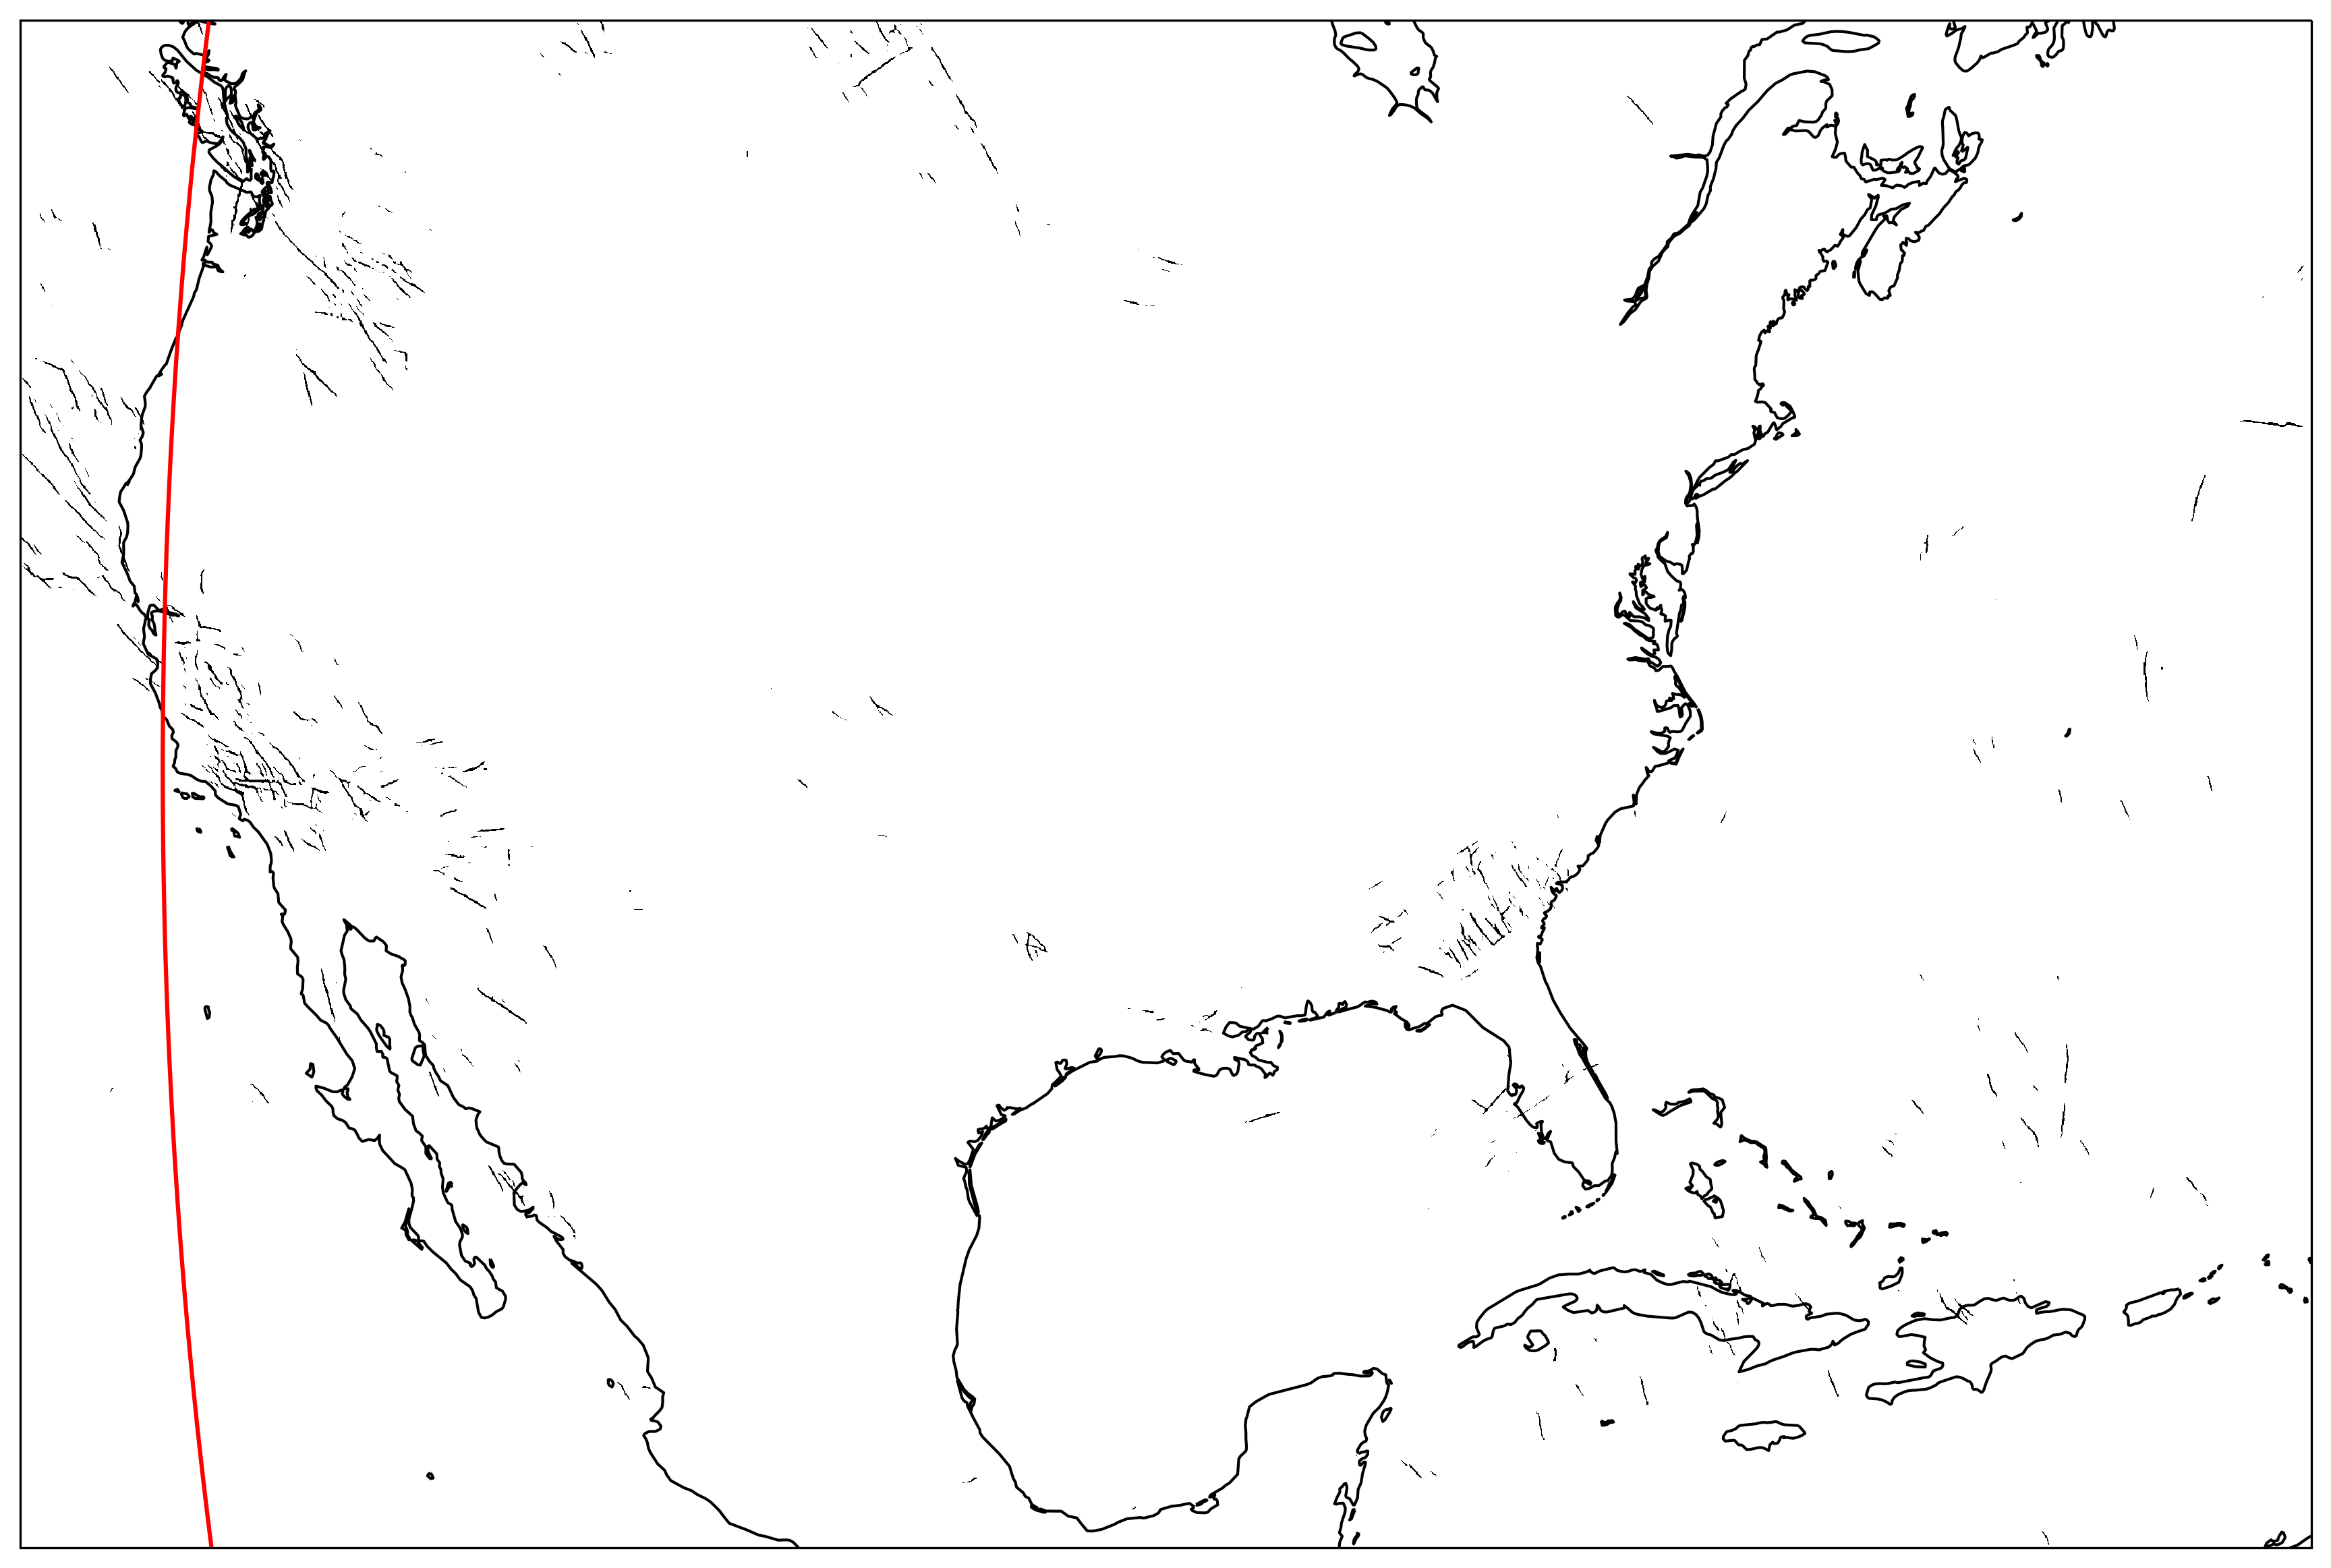

In [14]:
fig, ax = plt.subplots(figsize=(15,10), dpi=300, subplot_kw=dict(projection=ORTHO_PROJ))


ax.plot(*ground_track.get_coordinates(n_points=1000), transform=ccrs.PlateCarree(), c="r")
ax.imshow(np.ma.masked_array(mask, mask=mask==0.0), extent=ORTHO_EXTENT, origin="upper",
         cmap="gray")

ax.coastlines()
ax.set_extent(ORTHO_EXTENT, ORTHO_PROJ)

# Perform fine collocation

In [15]:
from contrails.meteorology.era5 import *

In [16]:
fine_df = fine_collocation(df, get_mask, get_ERA5_data, verbose=True)

Starting fine L1 collocation for CAL_LID_L1-Standard-V4-10.2018-01-01T20-44-02ZD_Subset.hdf


../src/collocation.py:597: UserWarning: Discarding nonzero nanoseconds in conversion.
  advection_time = pd.Timestamp(sub_times[median_idx]).to_pydatetime()
../src/collocation.py:597: UserWarning: Discarding nonzero nanoseconds in conversion.
  advection_time = pd.Timestamp(sub_times[median_idx]).to_pydatetime()
../src/collocation.py:597: UserWarning: Discarding nonzero nanoseconds in conversion.
  advection_time = pd.Timestamp(sub_times[median_idx]).to_pydatetime()


Finished fine L1 collocation for CAL_LID_L1-Standard-V4-10.2018-01-01T20-44-02ZD_Subset.hdf


In [17]:
fine_df["segment_number"] = fine_df.groupby("segment_start_lat").ngroup()

sub_df = fine_df[fine_df.segment_number == 0]

# Visualize results

In [18]:
fig, ax = plt.subplots(dpi=300, figsize=(15, 10))
ca.plot_backscatter(colorbar=True, cloud_filter=True, fig=fig, ax=ax, min_alt=8,
       max_alt=15.0, dist_axis=True, extent=[-135, -65, sub_df.iloc[0].segment_start_lat,
                                              sub_df.iloc[0].segment_end_lat])
# Add 200 m to cloud top positions for clarity, and only show every other for clairty
ax.scatter(sub_df.profile_id.values[::2] - sub_df.iloc[0].segment_start_idx,
           sub_df.caliop_top_height.values[::2] / 1000 + 0.2, c="w", label="Collocated positions", marker="v",
          ec="k")
ax.legend(loc="upper right", bbox_to_anchor=(1,1), frameon=True)

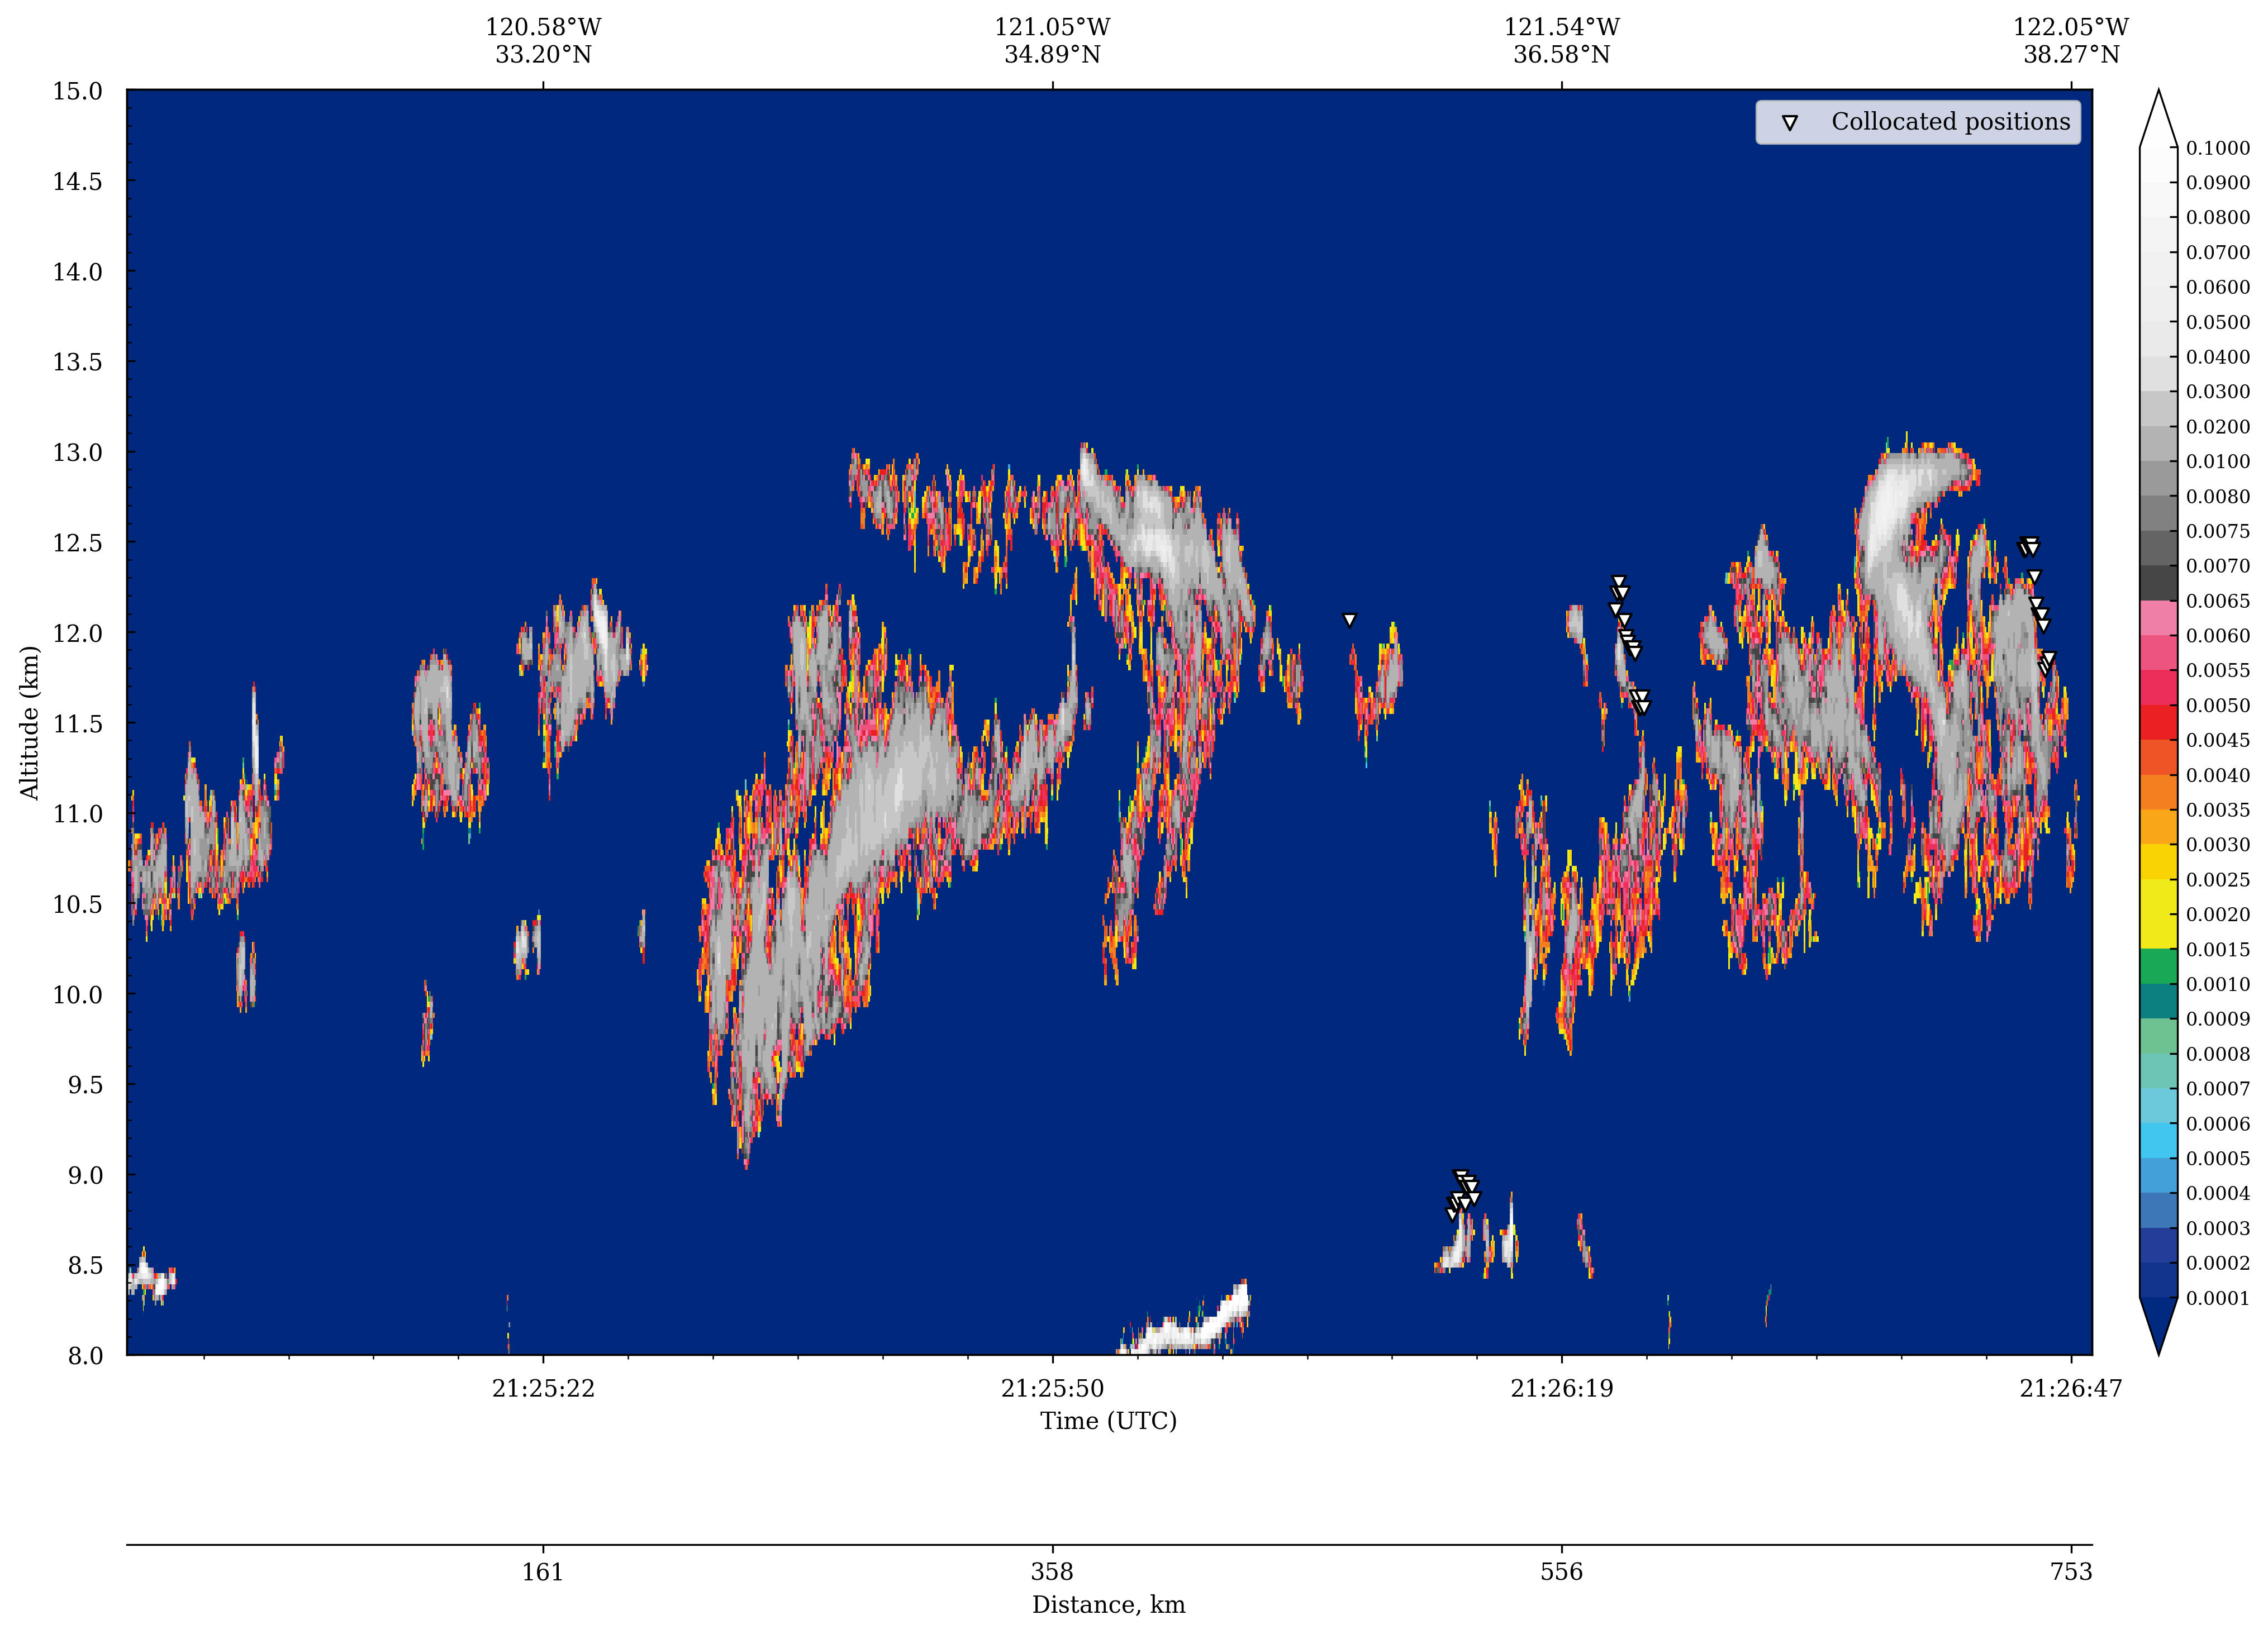

In [19]:
fig

In [17]:
from contrails.satellites.goes.reprojection import *
from contrails.satellites.goes.abi import *

from skimage.morphology import binary_dilation

In [18]:
goes_time = sub_df.iloc[0].goes_time
conus = True

nc = xr.open_dataset(get_reprojection_path(goes_time, product="ABI-L2-MCMIPC"))
ash = ash_from_nc(nc)

In [19]:
extent = [-135, -45, fine_df.iloc[0].segment_start_lat, 51.2]



b532, lons, lats, times = subset_caliop_profile(ca, "Total_Attenuated_Backscatter_532",
                                        extent, return_coords=True)


extent[0] = lons.min()
extent[1] = lons.max()


/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


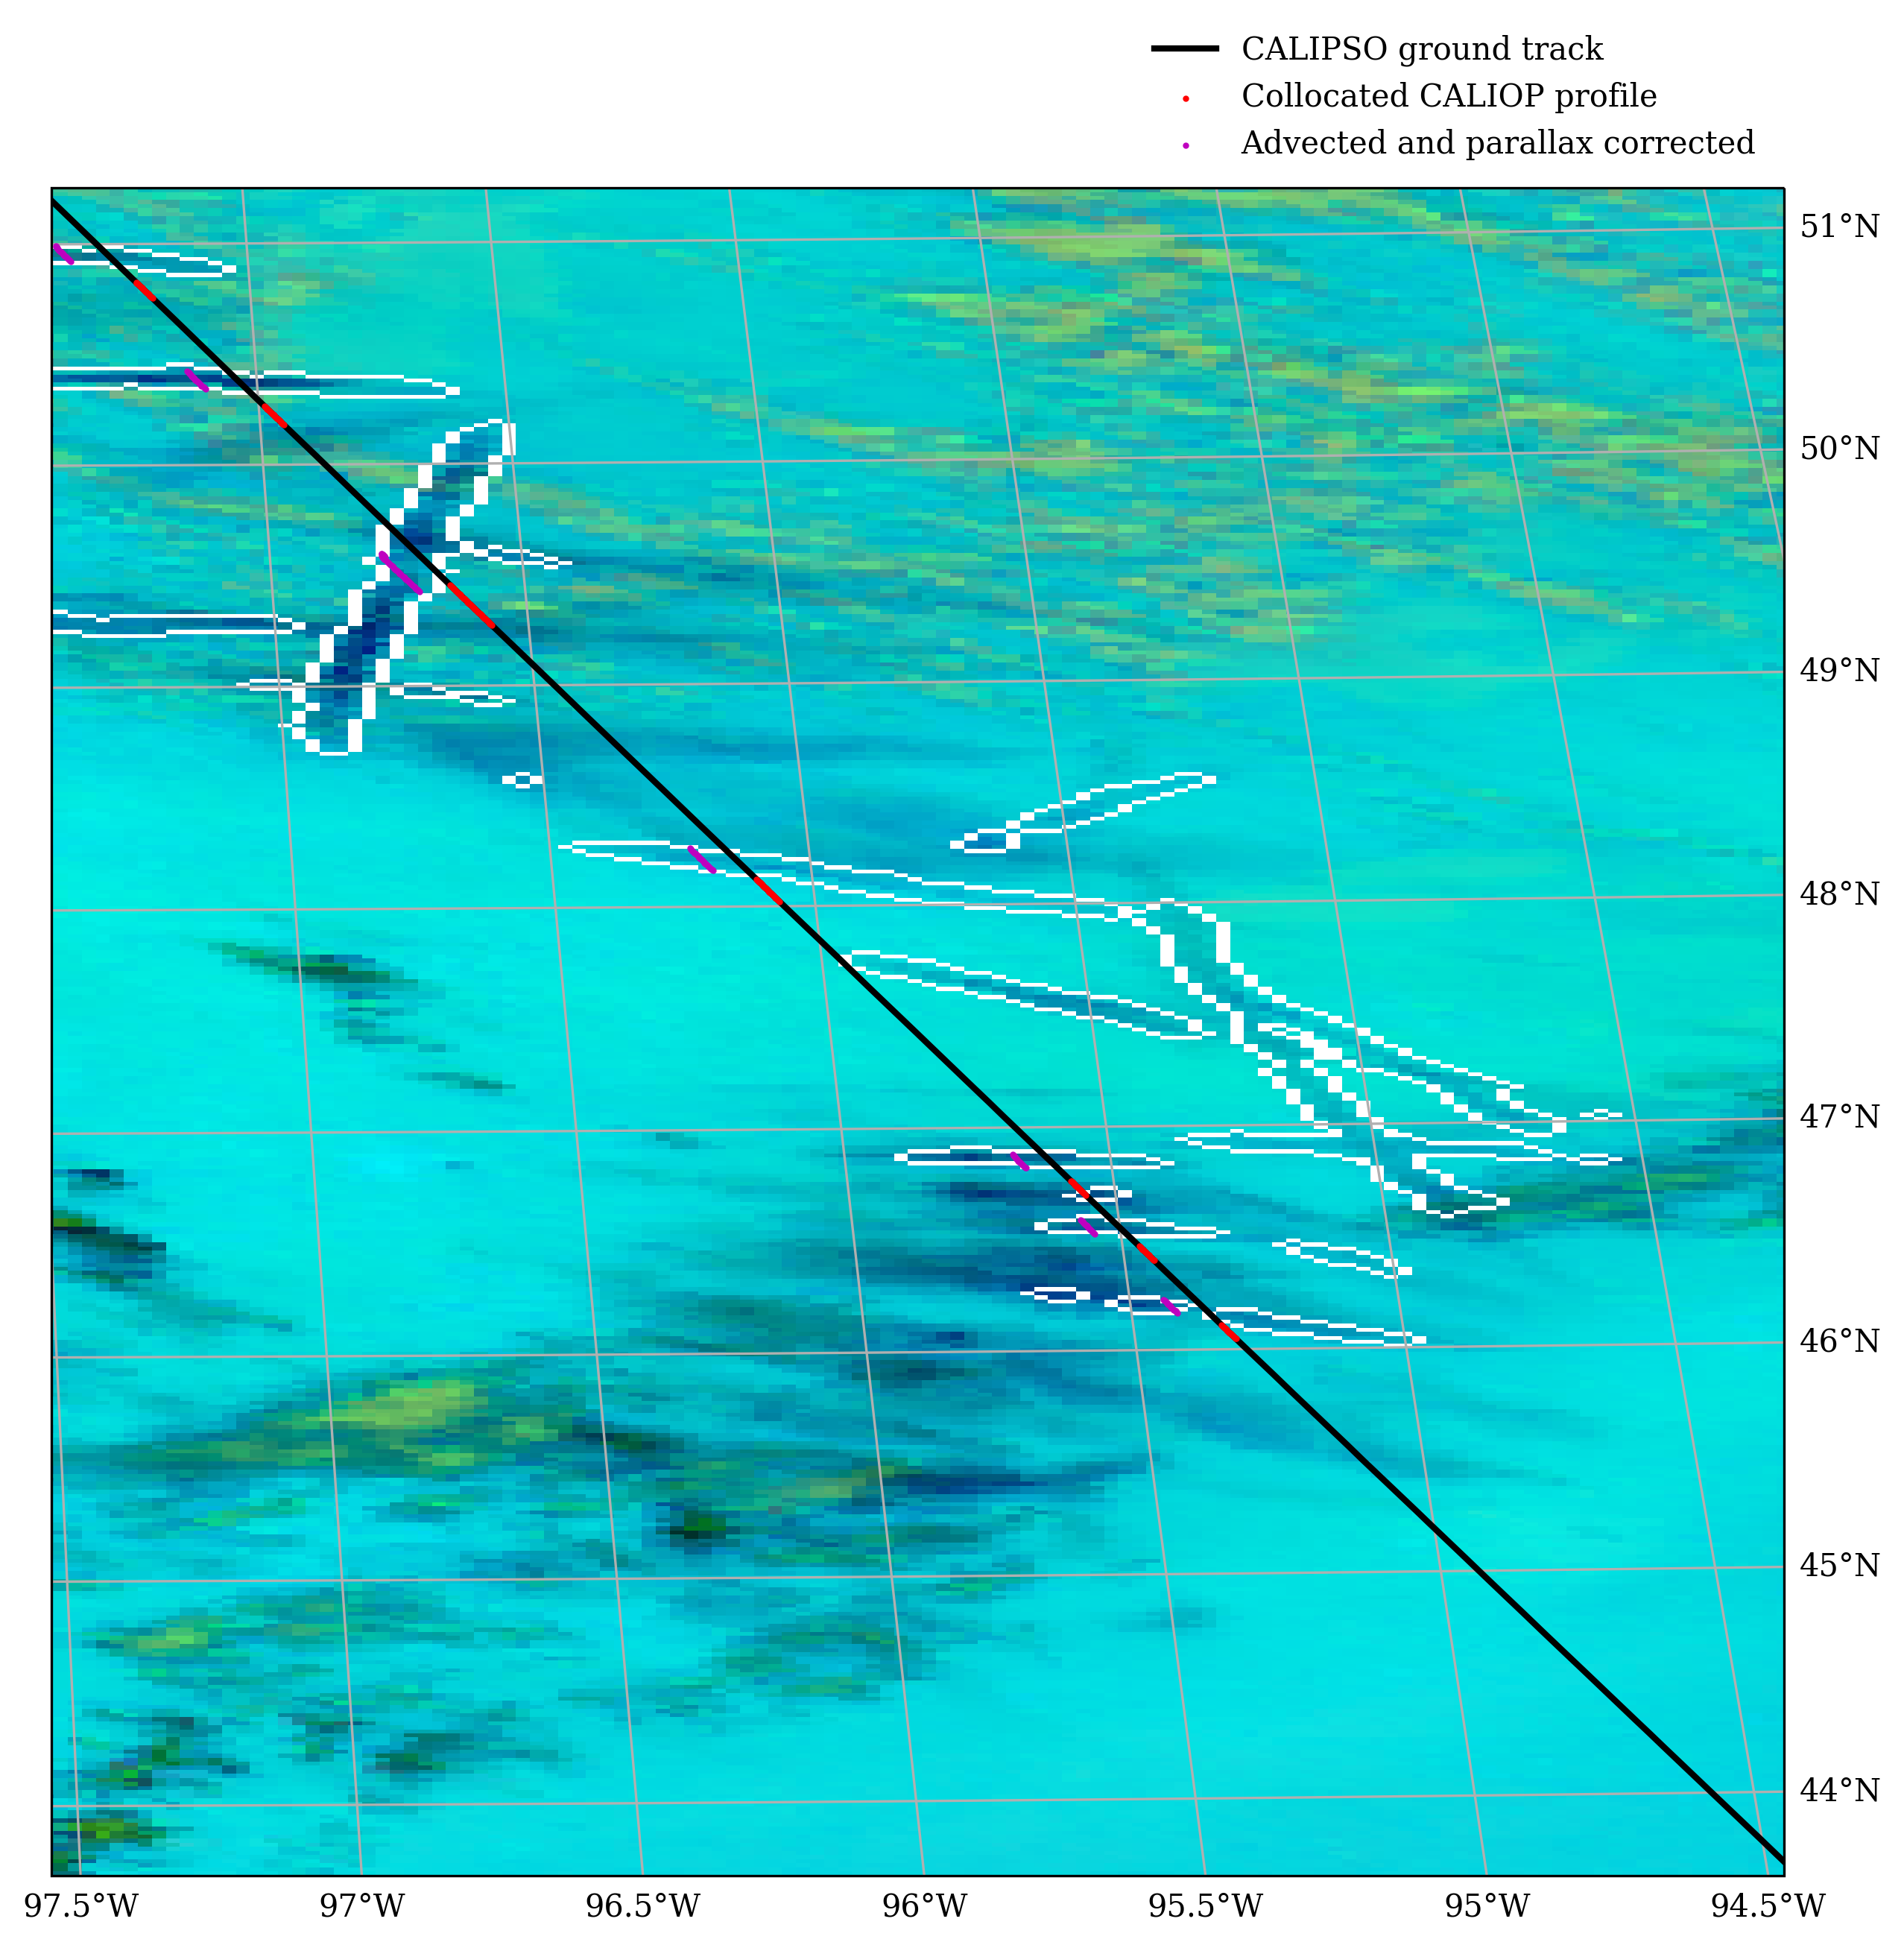

In [20]:
fig, gax = plt.subplots(figsize=(10,10), dpi=300, subplot_kw=dict(projection=ORTHO_PROJ))
mask = get_mask(goes_time, conus=conus)

boundaries = binary_dilation(mask) - mask

gax.imshow(ash, extent=ORTHO_EXTENT, origin='upper', transform=ORTHO_PROJ)
gax.imshow(np.ma.masked_array(boundaries, mask=(boundaries==0.)), extent=ORTHO_EXTENT,
           origin='upper', transform=ORTHO_PROJ, cmap="gray_r")
gax.set_extent(extent, ccrs.PlateCarree())
gax.set_aspect('auto')
gl = gax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False 

gax.plot(lons, lats, transform=ccrs.PlateCarree(), c="k", linewidth=2, label="CALIPSO ground track", zorder=3) 
gax.scatter(fine_df.caliop_lon.values, sub_df.caliop_lat.values, c="r",
            transform=ccrs.PlateCarree(), zorder=5, s=1, label="Collocated CALIOP profile")

gax.scatter(sub_df.caliop_lon_adv_parallax.values, sub_df.caliop_lat_adv_parallax.values, c="m",
            transform=ccrs.PlateCarree(), zorder=5, s=1, label="Advected and parallax corrected")

gax.legend(loc="lower right", bbox_to_anchor=(1,1), frameon=False)

In [ ]:
fig, ax = plt.subplots(dpi=300)

In [22]:
fine_df.to_pickle("figure1_data.pkl")